This POC involves some computing on modest datasets. You should have at least 1.5 GB of available RAM. If that's not possible, you'll have to shrink the datasets (reduce the number of columns) to be able to run it.

we'll use a dataset of hand-written digit images called MNIST. You can download the dataset from Canvas if you have not already done so.

The data comprises a train and test set, and train and test labels (ictrain and ictest). 

We'll be using numpy for this part of the lab so lets import it:

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We can read matrices in text format with numpy's loadtxt command. Text file input is slow, so this may take a few seconds.

In [57]:
train0=np.loadtxt("train.fmat.txt")

Lets look at the shape of this matrix:

In [58]:
train0.shape

(784, 4000)

The columns of the matrix are 28 * 28 images. Since we had to read the data from a 2d array, the structure is different. Let's look at one of the images. We'll also convert it to a matrix, so that more mathematical operators are defined on it. If you have trouble running the lab, reduce the dataset size by decreasing the column bound from 4000 below. 

In [59]:
train = np.asmatrix(train0[:,0:4000]) # <- decrease 4000 if memory is limited (optional)

and we'll save the number of training examples for later:

In [60]:
ntrain = train.shape[1];ntrain

4000

We can take any of the columns of the array, and reshape it to a 28 x 28 matrix:

In [61]:
img = train[:,0].reshape([28,28])

To look at the image, we can use Matplotlib's imshow function. We give it the image, plus a color map which maps the data values 0..255 to grayscale colors:

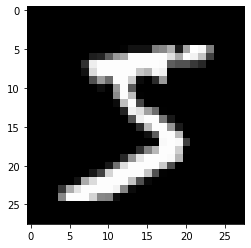

In [62]:
plt.imshow(img,cmap='gray')

Try some different images:

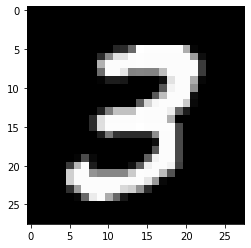

In [63]:
img2 = train[:,7].reshape([28,28])
plt.imshow(img2,cmap='gray')

Let us create a 10x10 array of the first 100 images and show it below. It's probably easiest to make a 280 x 280 array, and fill it with the individual images. Let us also scale the displayed image so that it is big enough to see individual images, i.e., so that it fills most of the browser window. 

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


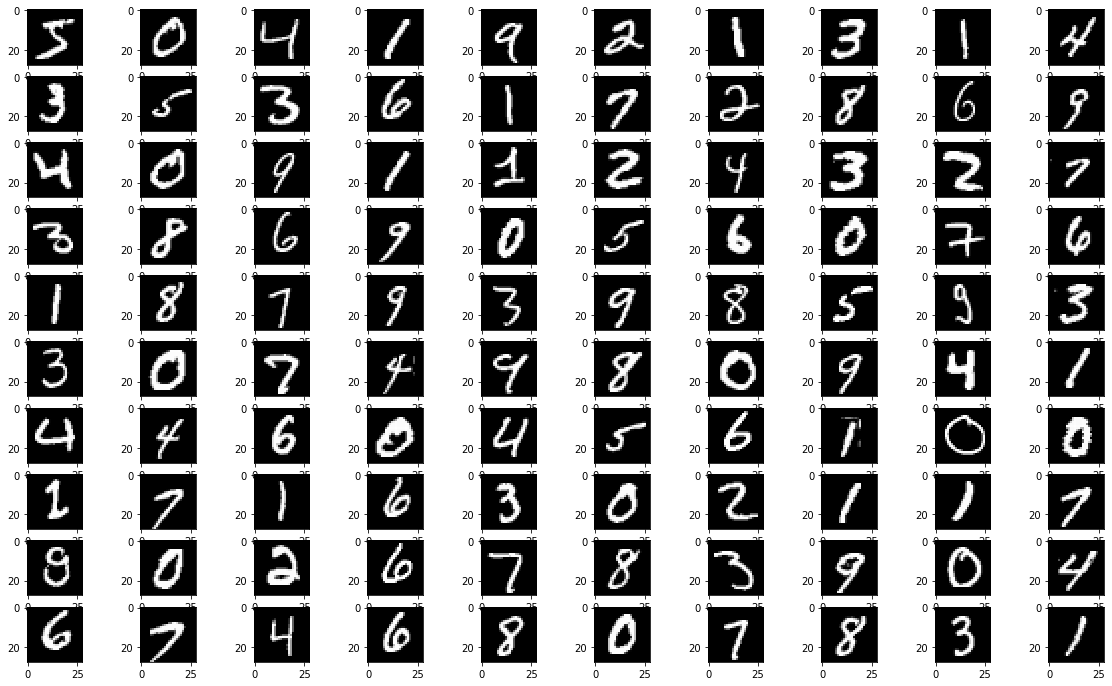

In [64]:

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)
fig, ax = plt.subplots(10, 10)
ax = ax.ravel()
for idx,ax in enumerate(ax):
    img2 = train[:,idx].reshape([28,28])
    ax.imshow(img2,cmap='gray')
plt.show()

## Computing Test/Train Set Distances

Next we need to compute the pairwise distances between our test and training set. Check the test set dimensions:

In [65]:
test0=np.loadtxt("test.fmat.txt")
test=test0[:,0:2000]
ntest=test.shape[1];ntest

2000

The squared euclidean distance between two vector x and y is the squared length of their difference. We can write it as
<pre>(x-y) dot (x-y)</pre>
When working with matrices, we can also use a matrix formula, which is
<pre>transpose(x-y) * (x-y)</pre>
We'll use the shorthand ".T" for the transpose, and then we can write:
<pre>(x-y) dot (x-y) = x dot x - 2 x.T * y + y dot y</pre>
This formula works for x and y which are single columns. We chose this combination of dot and transpose product so we can generalize it to matrices of points.

We would like to efficiently compute a ntest x ntrain matrix of all pairwise distances using this formula. The first term should be the x dot products, which we can compute like this:

In [66]:
xdots = np.sum(np.multiply(test,test),0).reshape(ntest,1) * np.ones((1,ntrain))

Note that we had to multiply by a row-vector of ones to reproduce the x-product for each y. The formula for y dot products is similar:

In [67]:
ydots = np.ones((ntest, 1)) * np.sum(np.multiply(train,train),0).reshape(1,ntrain) 

Finally, we can complete the distance formula by adding the cross-terms:

In [68]:
dists = xdots + ydots - 2 * np.transpose(test) * train

The raw distances will be larger for larger input instances, which is not what we want. We can improve the distance estimate by normalizing the lengths of test and train instances:

Let us produce a normalized distance matrix ndists by dividing by the eucliden length of the test and train points. (we already have the squared euclidean lengths of all the test and train points)

In [69]:

ndists = dists/np.sqrt(np.multiply(xdots,ydots))

Now the i-th row of the distance matrix is the vector of distances from the i-th test point to the training points. To get the closest neighbors, we can sort this array along its rows (axis = 1). The argsort function returns the index of the closest points, which we can use to lookup their label. 

In [70]:
ibest = np.argsort(ndists,axis=1); ibest

matrix([[1673,  522, 3324, ..., 1131, 3607, 1080],
        [1609, 1874, 2738, ...,  418, 1080, 1031],
        [1697, 2301, 1658, ..., 1367, 2009, 3106],
        ...,
        [1130,   98, 1144, ..., 2732,  294, 3370],
        [3678,  350, 1960, ..., 1102, 3016, 3734],
        [3170, 3870, 1556, ..., 1031,  418, 1080]])

To look up the distances along a given row, we can use the ibest array to provide the column (training point) indices. 

In [71]:
irow = 0
ndists[irow,ibest[irow,:]]

matrix([[0.29291391, 0.30300264, 0.30331726, ..., 1.92484544, 1.98639867,
         2.0672592 ]])

And then to get their labels we should load the label data matrix:

In [72]:
labels = np.loadtxt("ictrain.imat.txt")

In [73]:
labels[ibest[irow,:]]

array([[7., 7., 7., ..., 1., 2., 1.]])

label which is the best match for test point 0 is

In [74]:

#7.0 is the best match for test point 0
labels[ibest[irow,0]]

7.0

Now we'll restrict ourselves to the k-nearest neighbors. We currently have all the neighbors as columns of the dists and ibest matrices. Let's produce the labels of only the k-nearest, which is simply:

In [75]:
k = 3

In [76]:
knlabels = labels[ibest]; knlabels

array([[7., 7., 7., ..., 1., 2., 1.],
       [2., 2., 2., ..., 8., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 4., 4., 4.],
       [9., 9., 9., ..., 0., 0., 0.],
       [5., 5., 5., ..., 1., 8., 1.]])

to get the k-nearest distances, we can sort the distances directly:

In [77]:
ndists[0,ibest[0,:]]

matrix([[0.29291391, 0.30300264, 0.30331726, ..., 1.92484544, 1.98639867,
         2.0672592 ]])

Now, let's find the majority vote for each label. First we need to count the votes in a matrix whose columns are the possible digits. You'll need to do this with loops, since Python lacks a general accumulate function.

In [78]:
votes = np.zeros((ntest,10))

Let us fill out the votes array with the predicted labels using the k nearest neighbors.

In [79]:

for i in range(ntest):
    for j in range(k):
        votes[i][int(knlabels[i][j])]+=1
votes 

array([[0., 0., 0., ..., 3., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 0.]])

Then we can find the position of the maximum of the votes, which will also be the digit label:

In [80]:
bestlabels = np.argmax(votes, axis=1); bestlabels

array([7, 2, 1, ..., 3, 9, 5])

How well did we do? Let's load the test labels and see:

In [81]:
testlabels0 = np.loadtxt("ictest.imat.txt")
testlabels = testlabels0[0:ntest]

We can directly compare the bestlabels (predicted) and the testlabels with == to compute matches. Matching labels will produce a 1 or 0 otherwise. To find the fraction of matches we simply take the mean of the 0-1 values. 

In [82]:
accuracy = np.mean(bestlabels == testlabels); accuracy

0.9125

Now lets try some other values of k. To speed things up, we'll skip the expensive sort steps, which we've already done anyway. 

In [83]:
for k in range(1,11):
    votes = np.zeros((ntest,10))
    for i in range(ntest):
        for j in range(k):
            votes[i][int(knlabels[i][j])]+=1

    bestlabels = np.argmax(votes, axis=1)

    print('accuracy with k',k,np.mean(bestlabels == testlabels))

accuracy with k 1 0.9095
accuracy with k 2 0.9055
accuracy with k 3 0.9125
accuracy with k 4 0.917
accuracy with k 5 0.9095
accuracy with k 6 0.911
accuracy with k 7 0.914
accuracy with k 8 0.91
accuracy with k 9 0.9105
accuracy with k 10 0.91


best value of k <= 10? What is the corresponding accuracy? 


Best value of k is 4 for which the accuracy is 91.7%

Now let's try weighting by inverse distance. Modify the last compute cell to use the inverse distance (you probably want to use the kndists matrix) as the vote. 

In [84]:
inv_dist = np.array(1/ndists)

for k in range(1,11):
    votes = np.zeros((ntest,10))
    for i in range(len(votes)):
        for j in range(k):
            votes[i][int(knlabels[i][j])]+=(1*inv_dist[i][j])

    bestlabels = np.argmax(votes, axis=1)

    print('accuracy at k',k,np.mean(bestlabels == testlabels))

accuracy at k 1 0.9095
accuracy at k 2 0.9035
accuracy at k 3 0.9145
accuracy at k 4 0.9135
accuracy at k 5 0.911
accuracy at k 6 0.905
accuracy at k 7 0.9125
accuracy at k 8 0.9085
accuracy at k 9 0.9085
accuracy at k 10 0.913


best value of k <= 10? What is the corresponding accuracy? 


Best value of k is 3 for which the accuracy is 91.45%

# Naive Bayes

documentation for Naive Bayes in Scikit-learn here http://scikit-learn.org/stable/modules/naive_bayes.html .

We want to classify our image data, and so we have to choose a feature distribution. Although the data for MNIST are real 0..255 brightness values, most values are either 0's or 255's so we'll threshold them to produce binary features. Then we can use the Bernoulli Naive Bayes classifier. 

We also need to transpose the data: Sckit-learn expects data points to be rows rather than columns.

In [85]:
btrain = np.transpose(train > 128)
btest = np.transpose(test > 128)

Now import the BernoulliNB classifier:

In [86]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()

Which creates a new Bernoulli Naive Bayes classifier. Now train the classifier on your binarized training data. 

In [87]:
model = nb.fit(btrain, labels)

Use the model to predict the labels of the binarized test data:

In [88]:
nbpreds = model.predict(btest)

And evaluate the predictions compared to the actual labels

In [89]:
np.mean(nbpreds == testlabels)

0.7805

How did the accuracy of Naive Bayes compare with the kNN classifier on this data? 

KNN classifier performs well in comparison with Naive Bayes classifier on this data. 
This is because Naive Bayes classifier assumes all pixel values are independent and also because of the transposition based on threshold.

How well this dataset fits the assumptions of the kNN and Naive Bayes models respectively?

Naive Bayes classifier usually makes a naive assumption that all the input dimensions are independent which is not true in this case. Here, the pixel values around the required pixel value may be not different. 

Whereas, KNN depends on the distance metric we use to compute the nearest distance and therefore accuracy depends on the same.

# Diagnosing Performance: Confusion Matrices

Let's dig a bit deeper into the results from both classifiers. One useful tool is a confusion matrix: this is a matrix index by the true labels and predicted labels, and holds the normalized counts of values in each element. We can form the matrix as follows.

We start with a matrix C such that C[i,j] is a count of the points with predicted label i and true label j. We then normalize C so that its columns add up to 1. Then the j^th column corresponds to true label j, and is a vector of the probabilities that a true label of j is classified as one of the other labels. 

In [90]:
def confCount(a0, b0):
    a = a0.astype('int64')
    b = b0.astype('int64')
    counts = np.zeros((10,10))
    for i in range(0,a.size):
        counts[b[i],a[i]] += 1
    return counts           
            

In the cell below, we compute the confusion matrix for the Naive Bayes classifier. 

In [91]:
ccounts = confCount(testlabels, nbpreds)
conf = ccounts / sum(ccounts,axis=0).reshape(10,1)
conf

array([[0.85714286, 0.        , 0.01142857, 0.        , 0.00571429,
        0.02857143, 0.02857143, 0.        , 0.00571429, 0.00571429],
       [0.        , 0.95726496, 0.03418803, 0.01709402, 0.00854701,
        0.00854701, 0.01282051, 0.05555556, 0.01709402, 0.0042735 ],
       [0.00456621, 0.        , 0.75342466, 0.00456621, 0.        ,
        0.00913242, 0.0456621 , 0.02283105, 0.02283105, 0.        ],
       [0.        , 0.        , 0.04830918, 0.79227053, 0.        ,
        0.11594203, 0.        , 0.        , 0.09661836, 0.01932367],
       [0.        , 0.        , 0.00460829, 0.00460829, 0.75576037,
        0.02764977, 0.04608295, 0.03225806, 0.02764977, 0.09677419],
       [0.05027933, 0.03351955, 0.00558659, 0.07821229, 0.00558659,
        0.67597765, 0.03910615, 0.00558659, 0.0726257 , 0.01117318],
       [0.03932584, 0.01123596, 0.04494382, 0.02247191, 0.03370787,
        0.01685393, 0.78651685, 0.        , 0.01123596, 0.        ],
       [0.        , 0.        , 0.0243902

Now in the cell below, we create a grayscale visualization of the confusion matrix. i.e. a 10 x 10 image whose elements are in the range 0..255 and are 255 times the values of the confusion matrix. 

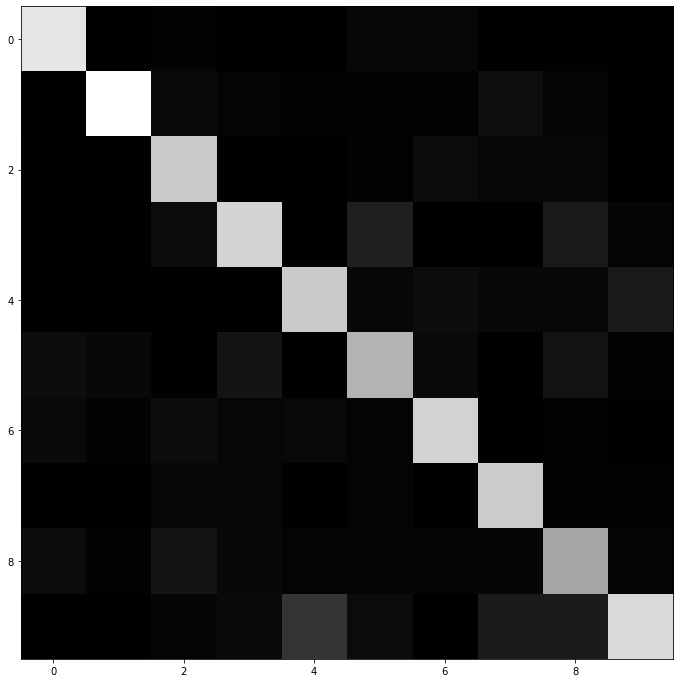

In [92]:
conf2 = conf*255
plt.imshow(conf2,cmap='gray')

Using the vizualization or the matrix itself, answer these questions:

Which digit is misclassified most often? How did you derive your answer from the confusion matrix?

How many mislabeled pairs are there (a pair of correct digits, incorrectly label) which have probability > 0.05 ? 

In [93]:
maxim = -1
row = col = 0
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        if i==j:
            continue
        if conf[i][j]>maxim:
            maxim=conf[i][j]
            row=i
            col=j
print(maxim,row,col)

0.20103092783505155 9 4


9 is misclassified as 4 more often. This is computed by finding maximum value by eliminating diagonal elements which are correctly classified.

In [94]:

counter = 0
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        if i==j:
            continue
        if conf[i][j]>0.05:
            counter+=1
print(counter)

11


Since every digit accuracy is more than 50%, we find 11 mislabeled pairs which have probability of more than 0.05